In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores
from fingerprint import FuzzyFingerPrint

In [5]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints

# ['pdbbind/P06202', 'pdbbind/P00749', 'pdbbind/P61823', 'pdbbind/P56817', 'pdbbind/P18031', 
#  'pdbbind/P07900', 'pdbbind/P00742', 'pdbbind/P00734', 'pdbbind/P00760', 'pdbbind/P00918']

receptor = 'pdbbind_final/P18031'
(xcrystals, xglides, ligs, structs) = load_data(receptor,
                                                w=[0,0,10,10,10,5,10,10,0,0.2,0,0,0],
                                                require_fp=True,
                                                combine_structs=False,
                                                glide_ifp='ifp/xglide_5',
                                                crystal_ifp='ifp/xcrystal_5',
                                                load_docking=True)

Loading crystal structures...
Loading glidescores...
0 of 39 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


In [ ]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

n = 500

get_ipython().magic(u'matplotlib inline')

print 'new docking'
best_rmsd_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: np.min(x) if x != [] else np.nan)
heatmap(best_rmsd_matrix, structs, ligs, red=4)
print np.nanmean(best_rmsd_matrix)

top_rmsd_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: x[0] if x != [] else np.nan)
heatmap(top_rmsd_matrix, structs, ligs, red=4)
print np.nanmean(top_rmsd_matrix)

#num_poses_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: len(x) if x != [] else np.nan)
#heatmap(num_poses_matrix, ligs, structs, red=300)
#print np.nanmean(num_poses_matrix)

#var_mat = get_docking_stats(ligs, structs, xglides, n, lambda x: np.var(x) if x != [] else np.nan)
#heatmap(var_mat, ligs, structs)

helpfully_frozen(ligs, structs, xglides, n)

In [6]:
get_ipython().magic(u'matplotlib inline')

def plot_docking_by_structure(ligs, s, glides, n_list=[0,5,25,300], title='', us_rmsds=[]):
    plt.plot([2,2],[0,1],'--k')
    li = [l for l in ligs if s in glides[l]]
    prop_ligands = np.cumsum([-1.0/len(li)] + [1.0/len(li) for l in li] + [1.0/len(li)])
    for n in n_list:
        rmsds = [min([glides[l][s].poses[i].rmsd for i in range(min(n, max(glides[l][s].poses.keys()))+1)]) for l in li]
        rmsds.sort()
        rmsds = [0] + rmsds + [rmsds[-1]]

        #top_rmsds = [glides[l][s].poses[0].rmsd for l in li]
        #top_rmsds.sort()
        #top_rmsds = [0] + top_rmsds + [top_rmsds[-1]]

        plt.step(rmsds, prop_ligands, label=n)
        #plt.step(top_rmsds, prop_ligands, label=s)
        
    if len(us_rmsds) > 0:
        us_rmsds = sorted(us_rmsds)
        us_rmsds = [0] + us_rmsds + [us_rmsds[-1]]
        plt.step(us_rmsds, prop_ligands, label='us')
    plt.gca().set_xlim([0,6])
    plt.gca().set_ylim([0,1])
    plt.xlabel('RMSD [A]')
    plt.ylabel('Cumulative Proportion of Ligands')
    plt.title(title+' '+s)
    plt.legend()
    plt.show()

In [ ]:
pdbbind = ['pdbbind/P06202', 'pdbbind/P00749', 'pdbbind/P61823', 'pdbbind/P56817', 'pdbbind/P18031', 
           'pdbbind/P07900', 'pdbbind/P00742', 'pdbbind/P00734', 'pdbbind/P00760', 'pdbbind/P00918']

best_resolution = {'B1AR_all':'4BVN', 'B2AR_all':'2RH1',# 'CHK1_all':'2YEX', 
                   'TRMD':'4YQD', 'AR':'3L3X', 'CDK2':'4EK4', 'MAP4K4':'4OBO', 'FXR':'1OSH'}

for r in ['B1AR_all', 'B2AR_all', 'CHK1_all', 'TRMD', 'AR', 'CDK2', 'MAP4K4', 'FXR'] + pdbbind:
    try:
        (xcrystals, xglides, ligs, structs) = load_data(r, w=[10,10,10,1,0], require_fp=False, crystal_ifp='ifp/xcrystal_ifp_3',
                                                        combine_structs=False, load_docking=True)
        plot_docking_by_structure(ligs, best_resolution.get(r, structs[0]), xglides, title=r)
    except: pass

In [7]:
get_ipython().magic(u'matplotlib inline')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def interaction_heatmap(A, structs, res, cluster_labels=None):
    fig, ax = plt.subplots()

    colors = {0:'red',1:'blue',2:'green',3:'orange'}

    df = pd.DataFrame(A, structs, res)
    
    # plotting
    #fig,ax = plt.subplots()
    def i_matrix(A, res, i):
        aa = np.zeros(A.shape)
        for j, r in enumerate(res):
            if r[1] == i:
                aa[:,j] = A[:,j]
            else:
                aa[:,j] = np.nan*A[:,j]
        return aa
    
    ax.matshow(i_matrix(A, res, 5), cmap=cm.Purples, vmin=0, vmax=np.max(A))
    ax.matshow(i_matrix(A, res, 3), cmap=cm.Greys, vmin=0, vmax=np.max(A))
    ax.matshow(i_matrix(A, res, 2), cmap=cm.Reds, vmin=0, vmax=np.max(A))
    ax.matshow(i_matrix(A, res, 4), cmap=cm.Blues, vmin=0, vmax=np.max(A))
    ax.matshow(i_matrix(A, res, 9), cmap=cm.Greens, vmin=0, vmax=np.max(A))
    ax.matshow(i_matrix(A, res, 6), cmap=cm.Purples, vmin=0, vmax=np.max(A))
    ax.matshow(i_matrix(A, res, 7), cmap=cm.Greys, vmin=0, vmax=np.max(A))

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(A.shape[1]), minor=False)
    ax.set_yticks(np.arange(A.shape[0]), minor=False)
    #ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    if cluster_labels is not None:
        for c in range(max(cluster_labels)):
            num_in_c = sum([1 for i in cluster_labels if i <= c]) - 0.5
            ax.plot(ax.get_xlim(), [num_in_c, num_in_c], linewidth = 4, c="k")

    ax.set_xticklabels(res, minor=False, rotation = 'vertical')
    ax.set_yticklabels(structs, minor=False)
    plt.title('')
    plt.xlabel('interactions')
    plt.ylabel('crystal structures')
    
    square_size = 0.5
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(square_size*len(structs), square_size*len(res))
    
    plt.show()

In [8]:
# To do:
# 1) fingerprint -> vector (dict)
# 2) cluster vectors
# 3) sort based on cluster
# 4) show clusters

def get_fp_vectors(crystals, i_type=[0,1,2]):
    all_interactions = {}
    fp_map = {}
    fp_vectors = {}
    for s in crystals:
        if s not in fp_map:
            fp_map[s] = {}
        for r in crystals[s].fp.feats:
            for i in i_type:
                if crystals[s].fp.feats[r][i] != 0:
                    fp_map[s][(r,i)] = crystals[s].fp.feats[r][i]**2
                    #if (r,i) not in all_interactions:
                    all_interactions[(r,i)] = all_interactions.get( (r,i), 0) + fp_map[s][(r,i)]
                    
    all_interactions = sorted(all_interactions.keys(), key=lambda x:-all_interactions[x])
    return all_interactions, {s: [fp_map[s].get(x, 0) for x in all_interactions] for s in crystals}

[0 1 0 1 0 1 1 2 2 0 0 1 2 0 1 0 0 0 0 2 1 1 1 1 1 0 1 1 1 2 0 1 2 1 2 0 1
 1 0]


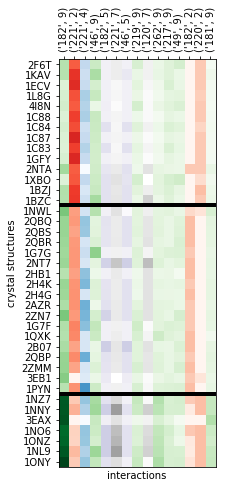

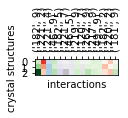

In [10]:
from sklearn.cluster import KMeans

i_indices = [2,3,4,5,6,7,9]
all_interactions, fp_vectors = get_fp_vectors(xcrystals,i_indices)
unsorted_ligs = fp_vectors.keys() # [l for l in fp_vectors.keys() if l != '2Y00']

def get_fp_matrix(sorted_ligs, fp_vectors):
    fp_matrix = np.zeros(( len(sorted_ligs), len(fp_vectors[sorted_ligs[0]]) ))
    for i, l in enumerate(sorted_ligs):
        fp_matrix[i,:] = fp_vectors[l][:]
    return fp_matrix

fp_mat_1 = get_fp_matrix(unsorted_ligs, fp_vectors)

kmeans = KMeans(n_clusters=3, random_state=0).fit(fp_mat_1)
print kmeans.labels_

sorted_ligs = sorted(unsorted_ligs, key=lambda x:kmeans.labels_[unsorted_ligs.index(x)])
fp_mat_2 = get_fp_matrix(sorted_ligs, fp_vectors)

num_i = 15

#interaction_heatmap(fp_mat_1[:,:num_i], unsorted_ligs, all_interactions[:num_i], 'crystal structures', 'residues')
interaction_heatmap(fp_mat_2[:,:num_i], sorted_ligs, all_interactions[:num_i], kmeans.labels_)
interaction_heatmap(kmeans.cluster_centers_[:,:num_i], [i for i in range(max(kmeans.labels_) + 1)], all_interactions[:num_i])

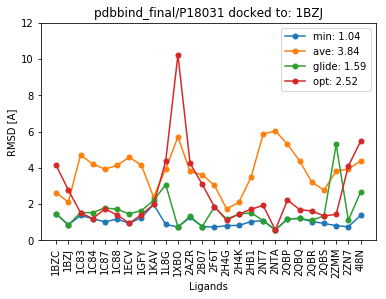

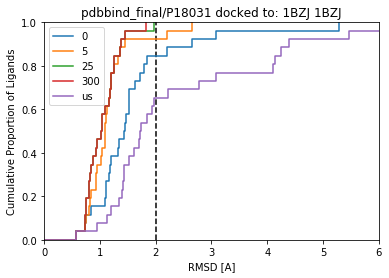

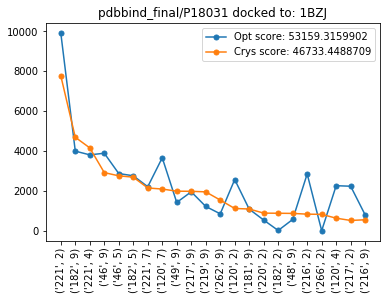

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.04|3.84|1.72|1.44|2.52|1.59|0.65|0.84|


In [14]:
get_ipython().magic(u'matplotlib inline')
for s in structs:
    rmsds = [min([xglides[l][s].poses[i].rmsd for i in range(min(25, max(xglides[l][s].poses.keys()))+1)]) for l in ligs]
    filt_ligs = [l for i, l in enumerate(ligs) if rmsds[i] < 2]
    scores = Scores(xglides, xcrystals, filt_ligs, s, 25)
    title = '{} docked to: {}'.format(receptor, s)
    final_rmsds = plot_final_rmsds(scores, title)
    a = scores.all_analysis
    plot_docking_by_structure(filt_ligs, s, xglides, n_list=[0,5,25,300], title=title, us_rmsds=a['opt'][1][:])
    
    crystal_cluster = {(l, -1):xcrystals[l].fp for l in filt_ligs}
    opt_cluster = [(l,p) for (l,p) in scores.optimized_scores.items()]
    opt_cluster = {(l,p):xglides[l][s].poses[p].fp for (l,p) in opt_cluster}
    plot_shared_interactions(crystal_cluster, c2=opt_cluster, max_r=20,
                             lab1='Crys', lab2='Opt', title=title,interactions=[i for i in range(12)])
    
    print struct, 'performance:'
    print_table({i:a[i][1][:] for i in a})

Loading crystal structures...
Loading glidescores...
0 of 22 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P28720 1ENU 19


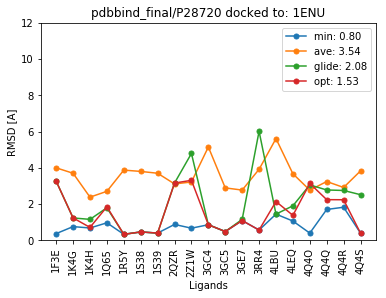

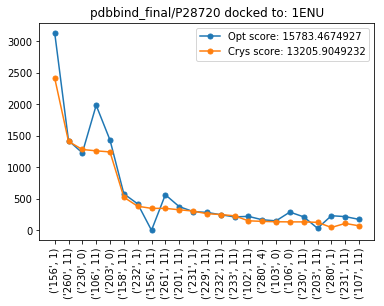

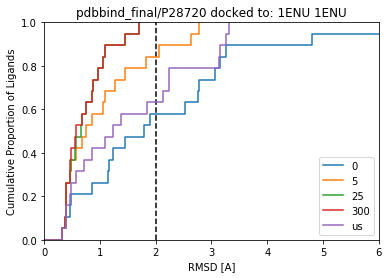

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|0.80|3.54|1.23|1.79|1.53|2.08|0.63|0.57|
Loading crystal structures...
Loading glidescores...
0 of 60 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P07900 1YET 32


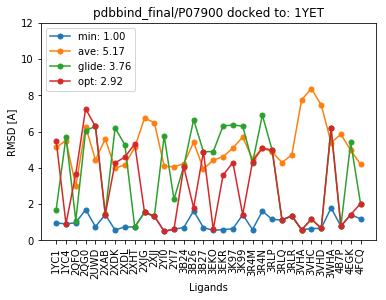

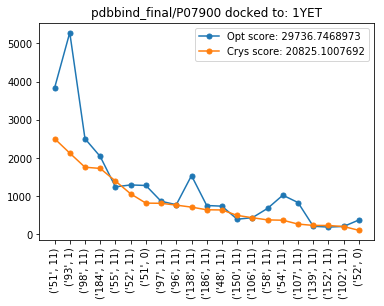

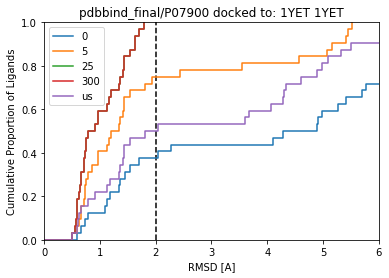

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.00|5.17|1.91|4.58|2.92|3.76|0.5|0.37|
Loading crystal structures...
Loading glidescores...
0 of 13 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P04587 1HVJ 2


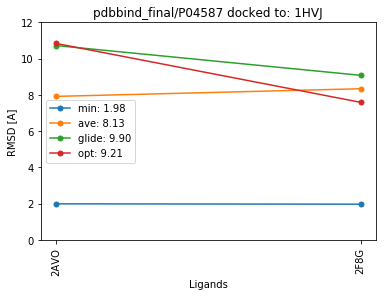

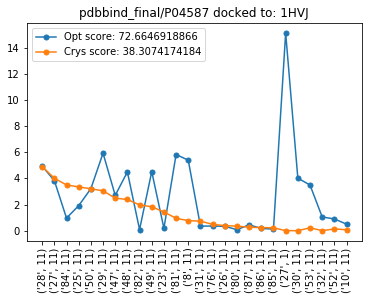

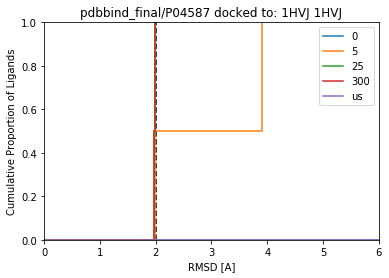

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.98|8.13|9.21|9.90|9.21|9.90|0|0|
Loading crystal structures...
Loading glidescores...
0 of 35 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P56817 1FKN 6


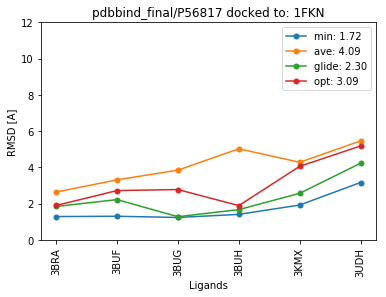

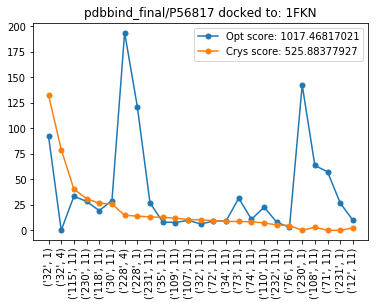

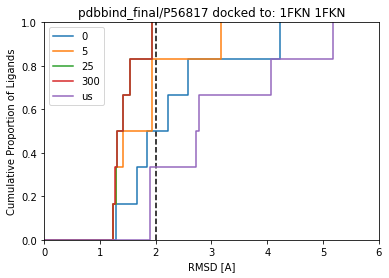

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.72|4.09|2.75|2.03|3.09|2.30|0.33|0.5|
Loading crystal structures...
Loading glidescores...
0 of 22 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P0A5R0 3COW 16


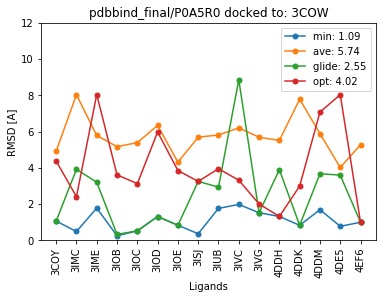

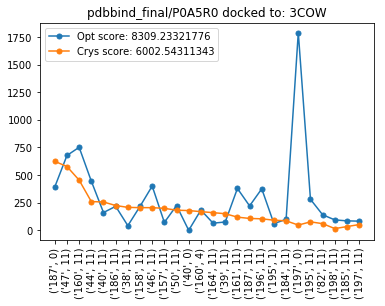

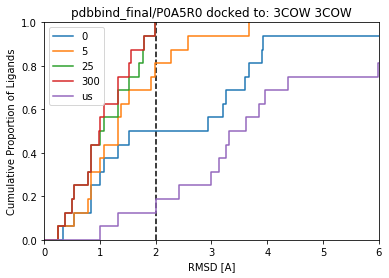

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.09|5.74|3.47|2.23|4.02|2.55|0.12|0.5|
Loading crystal structures...
Loading glidescores...
0 of 64 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00742 1XKA 0
Loading crystal structures...
Loading glidescores...
0 of 25 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/Q16539 1KV1 9


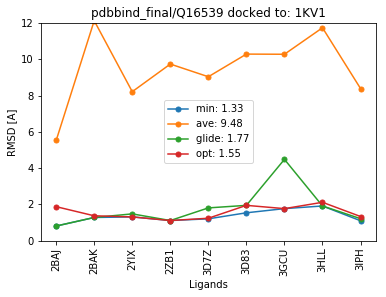

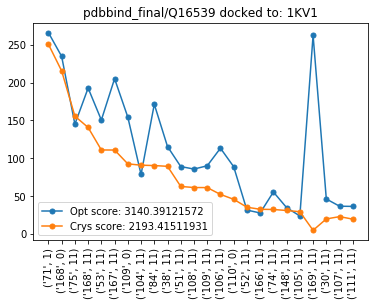

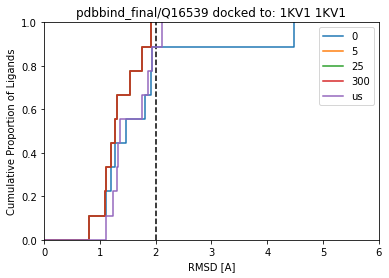

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.33|9.48|1.36|1.47|1.55|1.77|0.88|0.88|
Loading crystal structures...
Loading glidescores...
0 of 83 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00734 1FPC 48


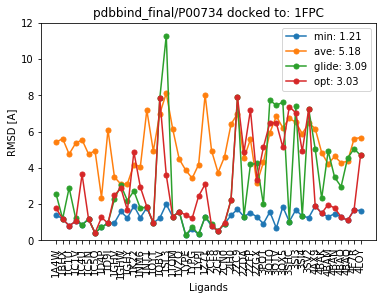

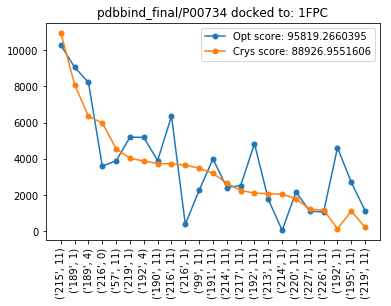

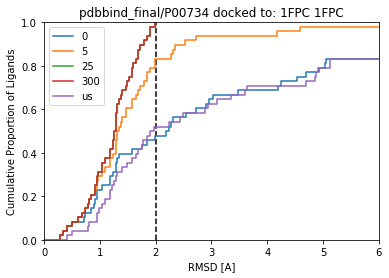

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.21|5.18|1.93|2.21|3.03|3.09|0.52|0.47|
Loading crystal structures...
Loading glidescores...
0 of 24 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/Q9Y233 3UI7 21


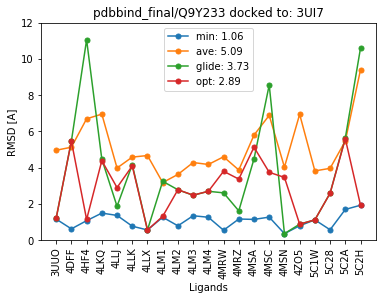

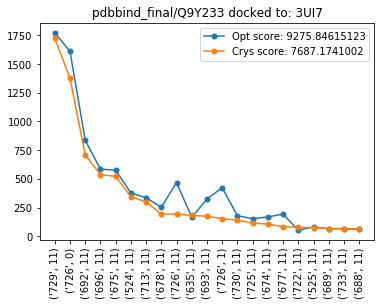

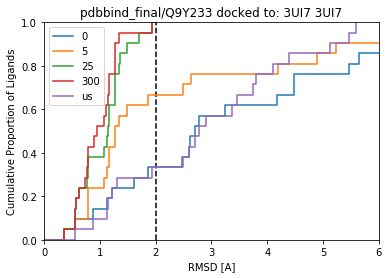

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.06|5.09|2.78|2.69|2.89|3.73|0.33|0.33|
Loading crystal structures...
Loading glidescores...
0 of 24 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P39900 1RMZ 16


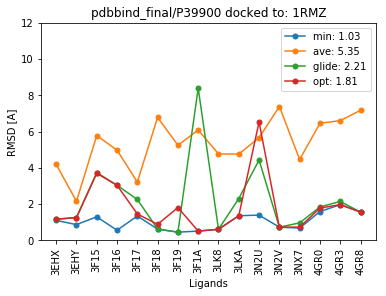

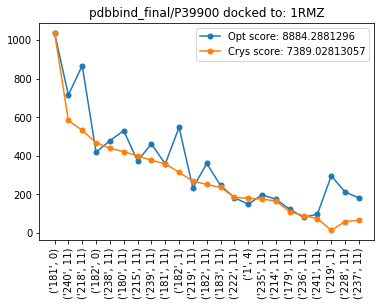

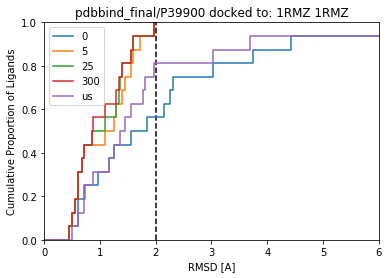

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.03|5.35|1.40|1.69|1.81|2.21|0.81|0.56|
Loading crystal structures...
Loading glidescores...
0 of 45 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P03366 1HOS 10


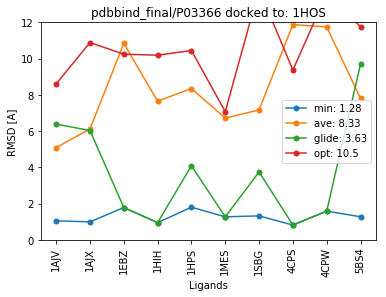

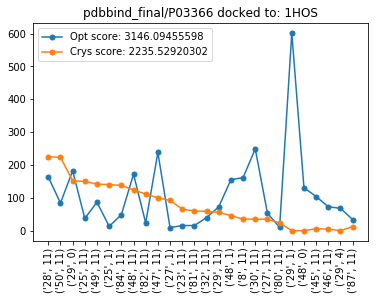

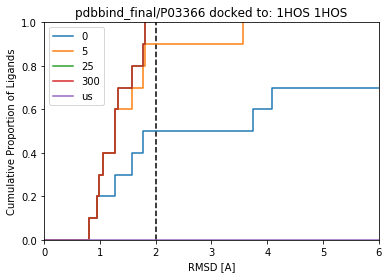

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.28|8.33|10.3|2.76|10.5|3.63|0|0.5|
Loading crystal structures...
Loading glidescores...
0 of 28 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P61823 1RPF 15


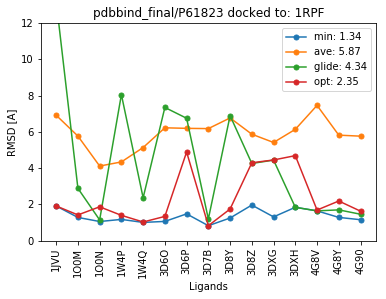

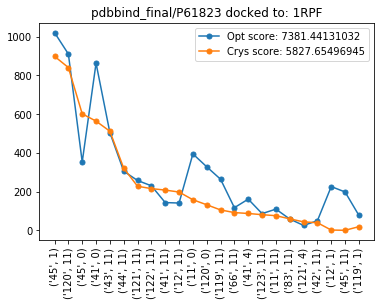

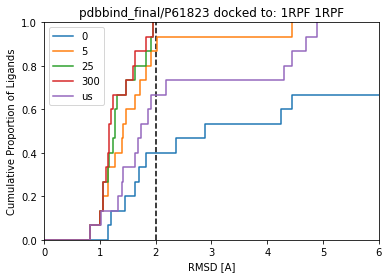

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.34|5.87|1.74|2.88|2.35|4.34|0.66|0.4|
Loading crystal structures...
Loading glidescores...
0 of 191 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
1
pdbbind_final/P00918 1BCD 86


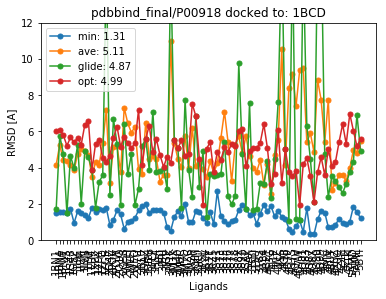

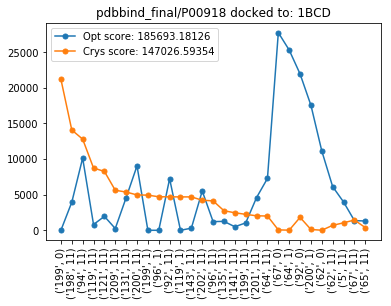

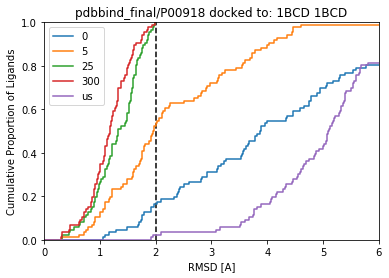

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.31|5.11|5.09|3.87|4.99|4.87|0.02|0.16|
Loading crystal structures...
Loading glidescores...
0 of 26 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00489 1A8I 21


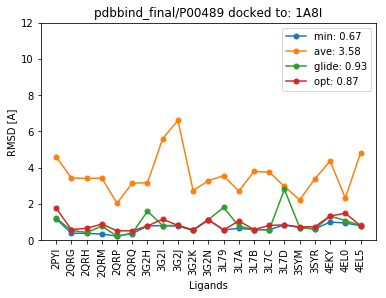

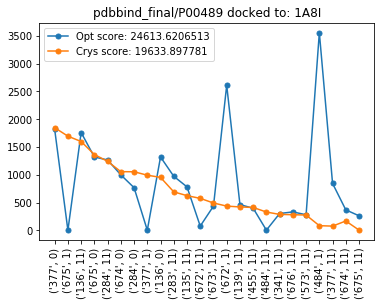

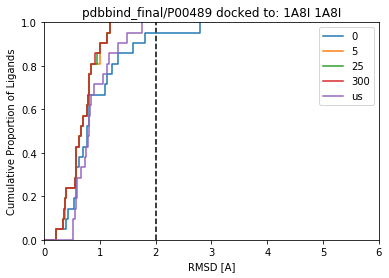

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|0.67|3.58|0.79|0.77|0.87|0.93|1.0|0.95|
Loading crystal structures...
Loading glidescores...
0 of 39 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P18031 1BZJ 25


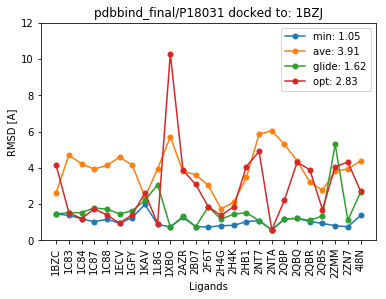

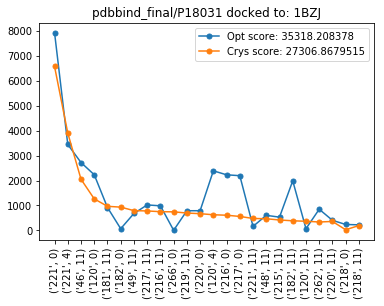

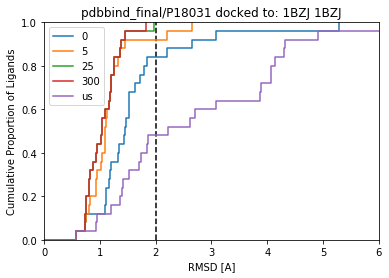

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.05|3.91|2.21|1.45|2.83|1.62|0.48|0.84|
Loading crystal structures...
Loading glidescores...
0 of 196 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00760 2TPI 54


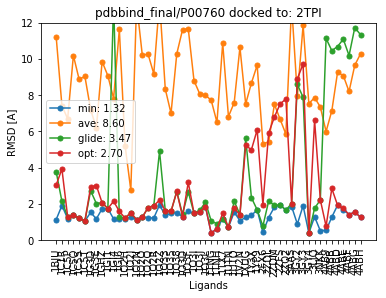

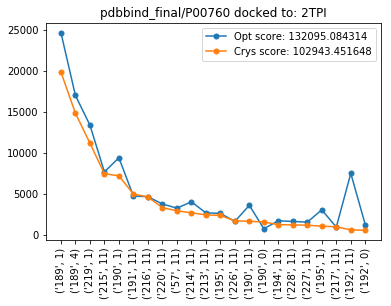

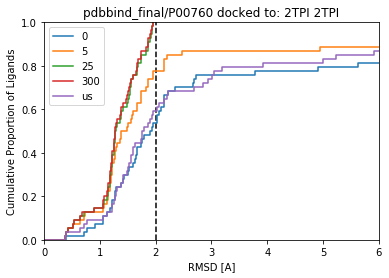

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.32|8.60|1.77|1.91|2.70|3.47|0.59|0.53|
Loading crystal structures...
Loading glidescores...
1 of 42 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P03367 1HVL 12


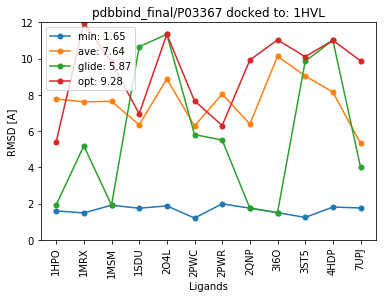

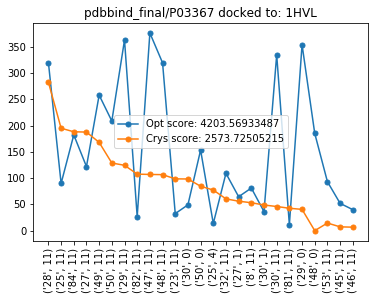

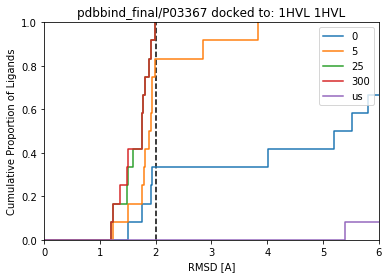

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.65|7.64|9.90|5.35|9.28|5.87|0|0.33|
Loading crystal structures...
Loading glidescores...
0 of 28 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00749 1EJN 19


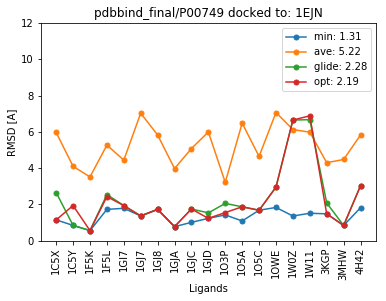

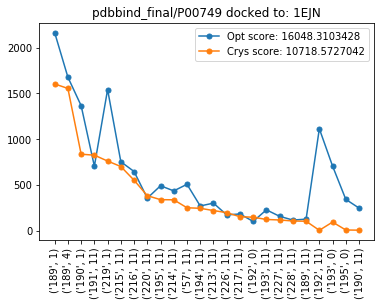

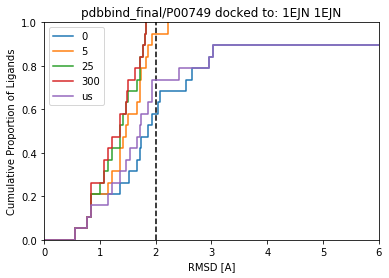

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.31|5.22|1.72|1.86|2.19|2.28|0.73|0.57|
Loading crystal structures...
Loading glidescores...
6 of 58 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P06202 2OLB 28


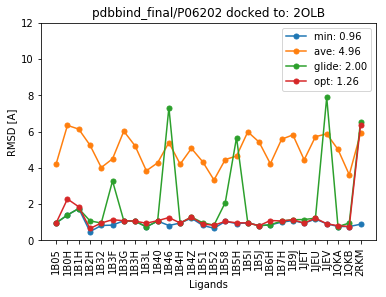

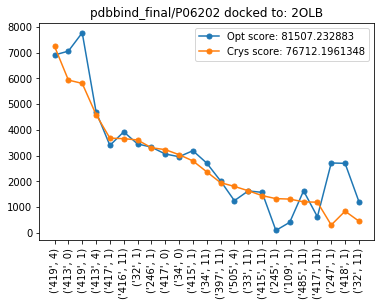

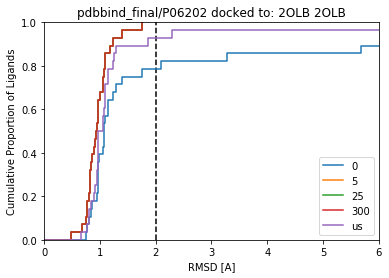

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|0.96|4.96|1.01|1.07|1.26|2.00|0.92|0.78|
Loading crystal structures...
Loading glidescores...
0 of 24 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P19491 1FTM 13


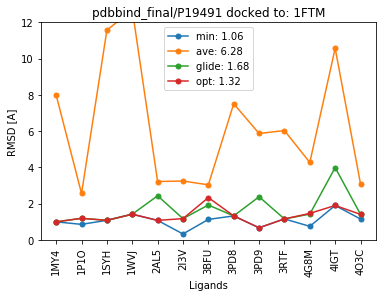

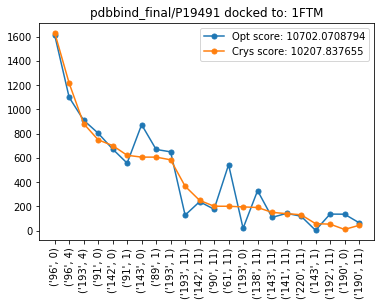

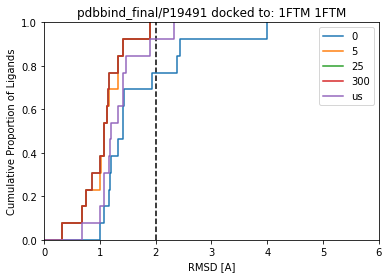

1BZJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.06|6.28|1.19|1.41|1.32|1.68|0.92|0.76|


In [23]:
## STEP 4:
## score all pairs of ligands
#print glides.keys()
#best_rmsd_matrix = best_pose(glides.keys(), glides.keys(), glides, 50)
#best_rmsd_matrix2 = best_pose(xglides.keys(), xglides.keys(), xglides, 25)

get_ipython().magic(u'matplotlib inline')

pdbbind = ['pdbbind/P06202', 'pdbbind/P00749', 'pdbbind/P61823', 'pdbbind/P56817', 'pdbbind/P18031', 
           'pdbbind/P07900', 'pdbbind/P00742', 'pdbbind/P00734', 'pdbbind/P00760', 'pdbbind/P00918']

for receptor in reversed(['pdbbind_final/{}'.format(s) for s in os.listdir('/scratch/PI/rondror/docking_data/pdbbind_final')]):
    #receptor = 'B2AR_all'
    (xcrystals, xglides, ligs, structs) = load_data(receptor,
                                                    w=[10,10,0,0,10,0,0,0,0,0,0,1,0],
                                                    require_fp=True,
                                                    combine_structs=False, 
                                                    glide_ifp='ifp/xglide_5',
                                                    crystal_ifp='ifp/xcrystal_5',
                                                    load_docking=True)
    #all_final = {}
        
    for s in os.listdir('/scratch/PI/rondror/docking_data/{}/grids'.format(receptor)):
        rmsds = [min([xglides[l][s].poses[i].rmsd 
                      for i in range(min(25, max(xglides[l][s].poses.keys()))+1)]) 
                 if s in xglides[l] else 10 for l in ligs]
        filt_lig = [l for i, l in enumerate(ligs) if rmsds[i] <= 2 and l != s]
        #filt_lig = [l for l in ligs if not np.isnan(best_rmsd_matrix[structs.index(struct)][ligs.index(l)])]
        #filt_lig = [l for l in ligs if l != struct] # [l for l in ligs if best_rmsd_matrix[structs.index(struct)][ligs.index(l)] < 1.8]
        print receptor, s, len(filt_lig)
        if len(filt_lig) == 0: continue
        scores = Scores(xglides, xcrystals, filt_lig, s, 25)
        title = '{} docked to: {}'.format(receptor, s)
        final_rmsds = plot_final_rmsds(scores, title)
        crystal_cluster = {(l, -1):xcrystals[l].fp for l in filt_lig}
        opt_cluster = [(l,p) for (l,p) in scores.optimized_scores.items()]
        opt_cluster = {(l,p):xglides[l][s].poses[p].fp for (l,p) in opt_cluster}
        plot_shared_interactions(crystal_cluster, c2=opt_cluster, max_r=20,
                                 lab1='Crys', lab2='Opt', title=title,interactions=[i for i in range(12)])

        #print opt_cluster.keys()

        a = scores.all_analysis
        plot_docking_by_structure(filt_lig, s, xglides, n_list=[0,5,25,300], title=title, us_rmsds=a['opt'][1][:])
        print struct, 'performance:'
        print_table({i:a[i][1][:] for i in a})
        #for i in a:
            #if i not in all_final: all_final[i] = []
            #all_final[i].extend(a[i][1][:])

    #print 'average across all data:'
    #print_table(all_final)

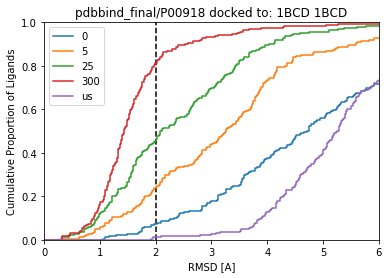

1BCD performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|2.50|5.65|5.25|4.71|5.48|5.61|0.01|0.07|


In [4]:
a = scores.all_analysis
plot_docking_by_structure(filt_lig, struct, xglides, n_list=[0,5,25,300], title=title, us_rmsds=a['opt'][1][:])
print struct, 'performance:'
print_table({i:a[i][1][:] for i in a})

Loading crystal structures...
Loading glidescores...
0 of 22 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P28720 1ENU 21


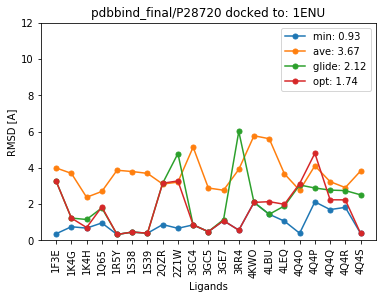

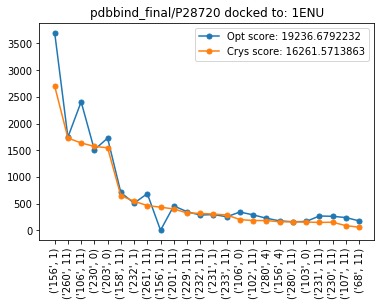

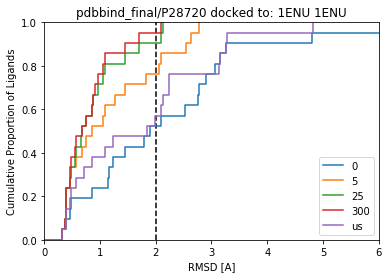

1ENU performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|0.93|3.67|1.84|1.90|1.74|2.12|0.57|0.52|
Loading crystal structures...
Loading glidescores...
0 of 60 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P07900 1YET 59


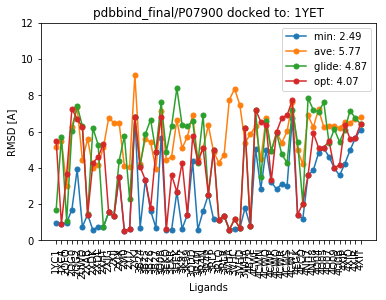

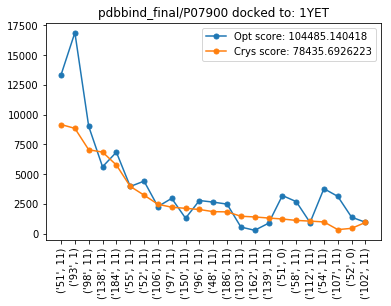

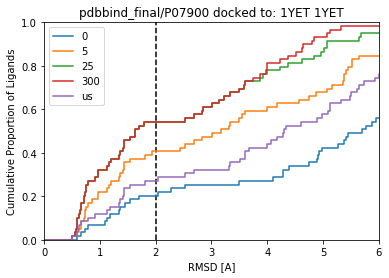

1YET performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|2.49|5.77|4.29|5.70|4.07|4.87|0.27|0.20|
Loading crystal structures...
Loading glidescores...
0 of 13 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P04587 1HVJ 12


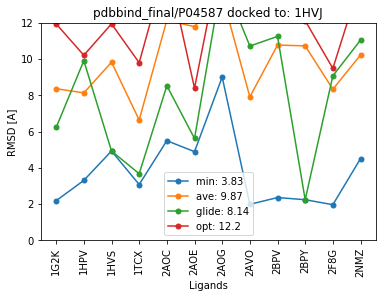

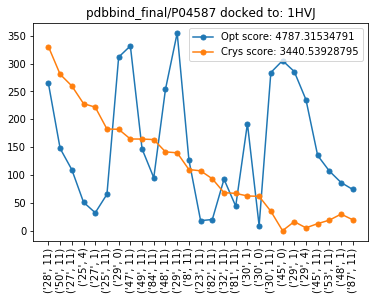

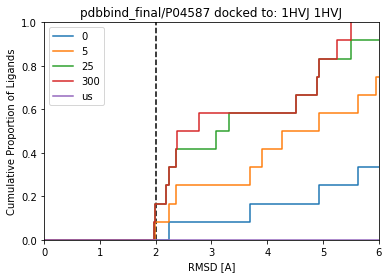

1HVJ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.83|9.87|12.0|8.81|12.2|8.14|0|0|
Loading crystal structures...
Loading glidescores...
0 of 35 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P56817 1FKN 34


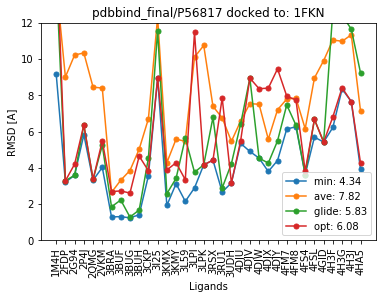

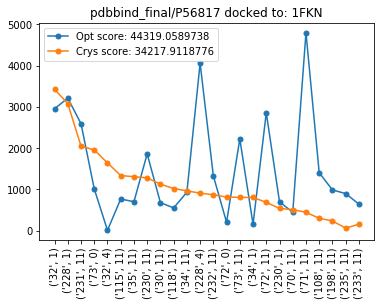

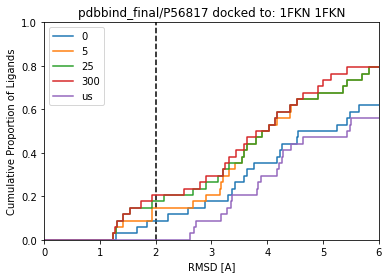

1FKN performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|4.34|7.82|5.45|4.89|6.08|5.83|0|0.08|
Loading crystal structures...
Loading glidescores...
0 of 22 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P0A5R0 3COW 21


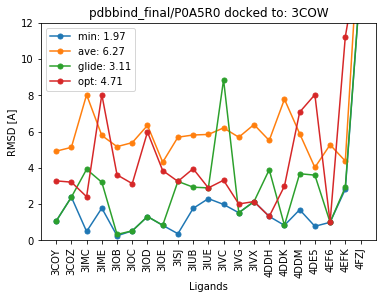

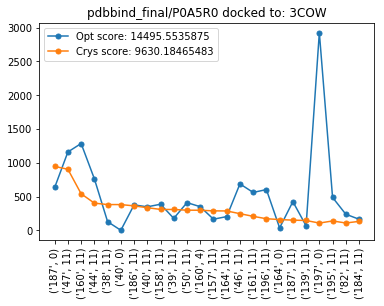

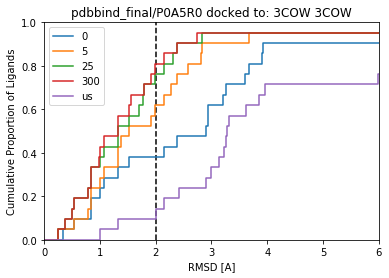

3COW performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.97|6.27|3.28|2.89|4.71|3.11|0.09|0.38|
Loading crystal structures...
Loading glidescores...
0 of 64 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00742 1XKA 60


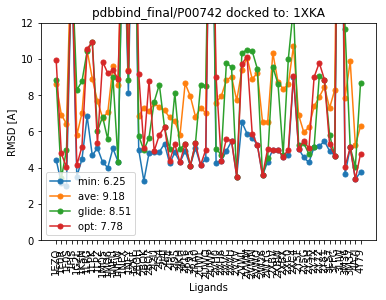

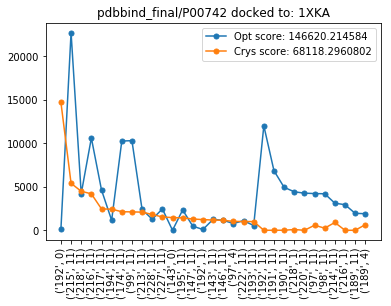

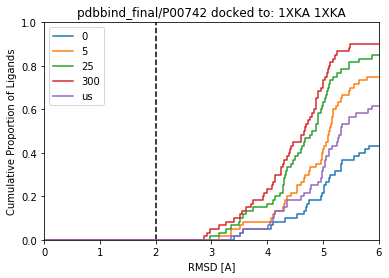

1XKA performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|6.25|9.18|5.32|7.86|7.78|8.51|0|0|
Loading crystal structures...
Loading glidescores...
0 of 25 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/Q16539 1KV1 24


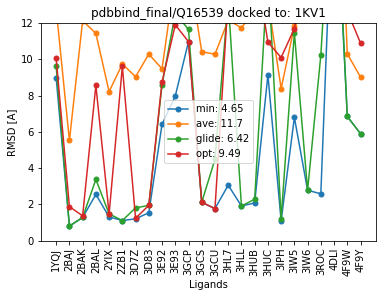

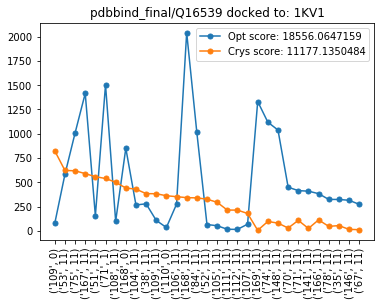

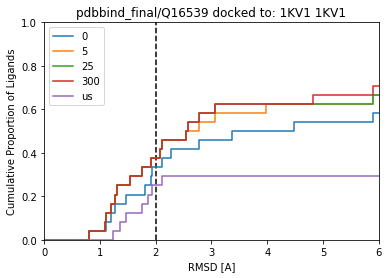

1KV1 performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|4.65|11.7|10.4|3.92|9.49|6.42|0.25|0.33|
Loading crystal structures...
Loading glidescores...
0 of 83 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P00734 1FPC 81


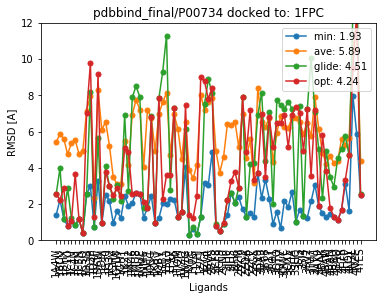

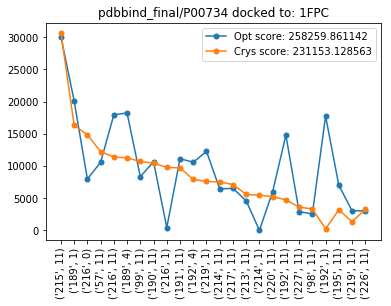

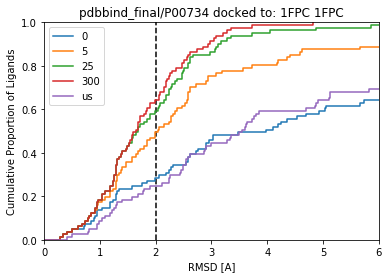

1FPC performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.93|5.89|3.54|3.97|4.24|4.51|0.24|0.28|
Loading crystal structures...
Loading glidescores...
0 of 24 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/Q9Y233 3UI7 23


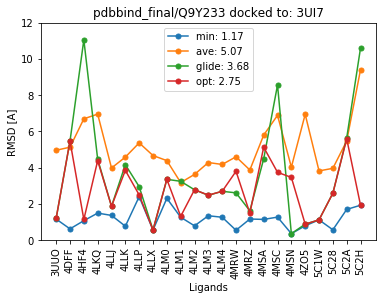

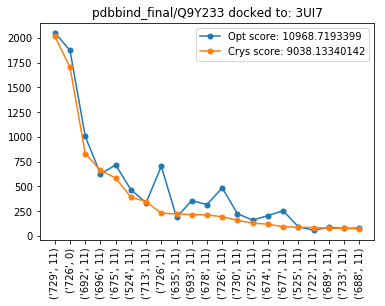

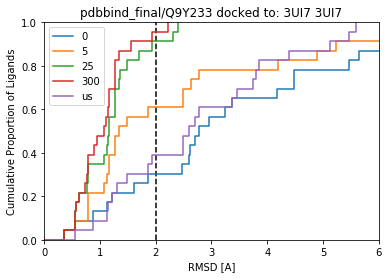

3UI7 performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.17|5.07|2.59|2.78|2.75|3.68|0.39|0.30|
Loading crystal structures...
Loading glidescores...
0 of 24 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P39900 1RMZ 23


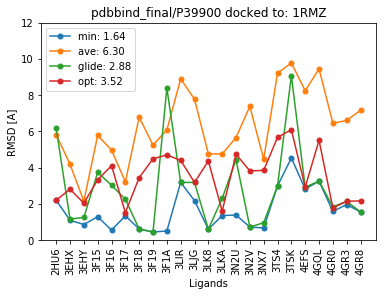

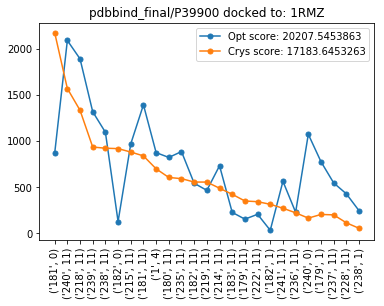

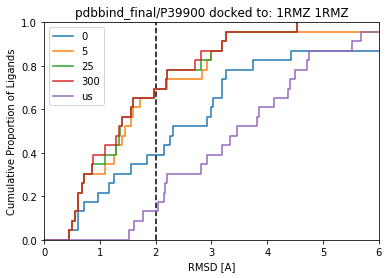

1RMZ performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|1.64|6.30|3.44|2.30|3.52|2.88|0.13|0.39|
Loading crystal structures...
Loading glidescores...
0 of 45 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P03366 1HOS 44


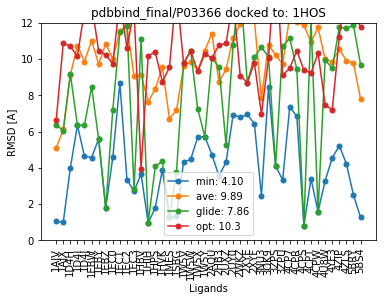

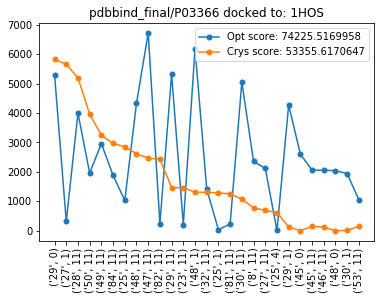

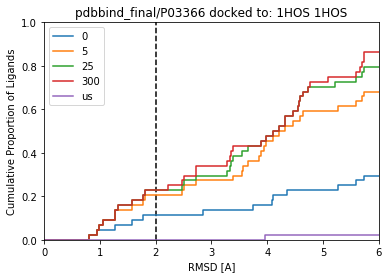

1HOS performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|4.10|9.89|10.2|9.31|10.3|7.86|0|0.11|
Loading crystal structures...
Loading glidescores...
0 of 28 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P61823 1RPF 27


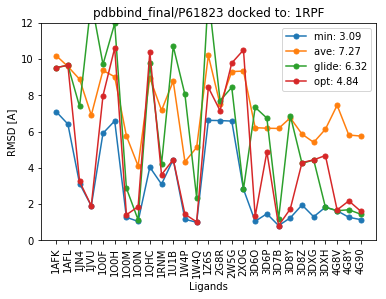

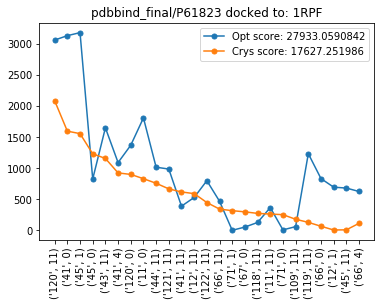

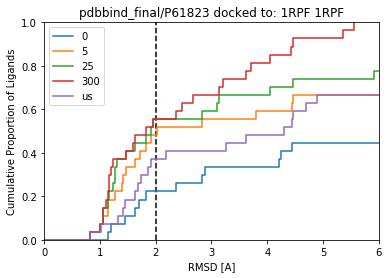

1RPF performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|4.29|6.89|4.84|6.32|0.37|0.22|
Loading crystal structures...
Loading glidescores...
0 of 191 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
1
pdbbind_final/P00918 1BCD 190


KeyboardInterrupt: 

In [6]:
get_ipython().magic(u'matplotlib inline')
for receptor in ['pdbbind_final/P0A5R0']:
#for receptor in reversed(['pdbbind_final/{}'.format(s) for s in os.listdir('/scratch/PI/rondror/docking_data/pdbbind_final')]):
    #receptor = 'B2AR_all'
    (xcrystals, xglides, ligs, structs) = load_data(receptor,
                                                    w=[10,10,0,0,10,0,0,0,0,0,0,1,0],
                                                    require_fp=True,
                                                    combine_structs=False, 
                                                    glide_ifp='ifp/xglide_5',
                                                    crystal_ifp='ifp/xcrystal_5',
                                                    load_docking=True)
    #all_final = {}
        
    for struct in os.listdir('/scratch/PI/rondror/docking_data/{}/grids'.format(receptor)):
        #filt_lig = [l for l in ligs if not np.isnan(best_rmsd_matrix[structs.index(struct)][ligs.index(l)])]
        filt_lig = [l for l in ligs if l != struct] # [l for l in ligs if best_rmsd_matrix[structs.index(struct)][ligs.index(l)] < 1.8]
        print receptor, struct, len(filt_lig)
        scores = Scores(xglides, xcrystals, filt_lig, struct, 25)
        title = '{} docked to: {}'.format(receptor, struct)
        final_rmsds = plot_final_rmsds(scores, title)
        crystal_cluster = {(l, -1):xcrystals[l].fp for l in filt_lig}
        opt_cluster = [(l,p) for (l,p) in scores.optimized_scores.items()]
        opt_cluster = {(l,p):xglides[l][struct].poses[p].fp for (l,p) in opt_cluster}
        plot_shared_interactions(crystal_cluster, c2=opt_cluster, max_r=20,
                                 lab1='Crys', lab2='Opt', title=title,interactions=[i for i in range(12)])

        #print opt_cluster.keys()

        a = scores.all_analysis
        plot_docking_by_structure(filt_lig, struct, xglides, n_list=[0,5,25,300], title=title, us_rmsds=a['opt'][1][:])
        print struct, 'performance:'
        print_table({i:a[i][1][:] for i in a})